In [1]:
# Check if TF is using gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15227401888956168741
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6727654441
locality {
  bus_id: 1
}
incarnation: 6461403867734021024
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [2]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [3]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

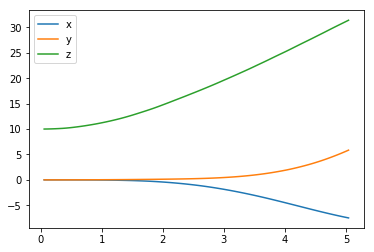

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

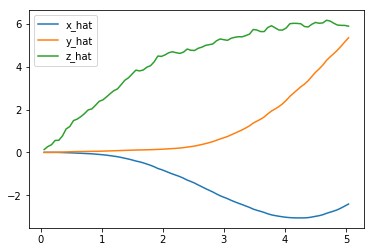

In [5]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

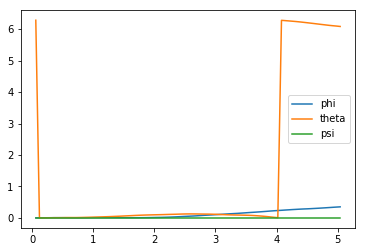

In [6]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

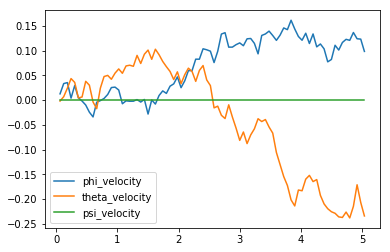

In [7]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

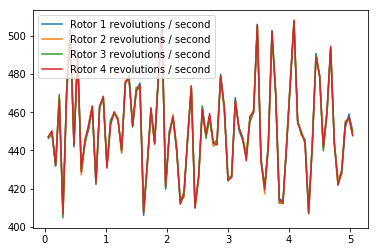

In [8]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [9]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[ -7.48949506   5.85052542  31.41997967   0.35168708   6.08540758   0.        ]
[-2.41167883  5.34693056  5.89127808]
[ 0.09816952 -0.23416906  0.        ]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [10]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 1

target_pos = np.array([50., 50., 50.])
init_pos = np.array([0., 0., 0., 0., 0., 0.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode =    1, score =  -2.990 (best =  -2.990), noise_scale = 0.05

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead

Episode: 1  Reward: -72.19127624562893 highScore: -72.19127624562893
[1.5000000000000009, 1.5371670715256189, 4.4017071019497331, 0.0, 3.9211457321319259, 0.41683049344520029, 0.0, 1.0899663758544709, 3.9824525010807625, -15.707259097041563, 14.581624976757231, -16.291835384286347, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 2  Reward: -72.17506617681617 highScore: -72.17506617681617
[1.5000000000000009, 1.4905553488969272, 4.4642145026921201, 0.0, 3.8933330059685591, 0.29181520565412988, 0.0, 0.96803420564551879, 4.0778512518505154, -15.80973676463571, 14.467049890860514, -16.264938301336606, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 3  Reward: -72.17885506590375 highScore: -72.17506617681617
[1.5000000000000009, 1.4437413232617415, 4.5808417707004834, 0.0, 2.8820399939982924, 1.0534380139704149, 0.0, 1.040611422637


Episode: 23  Reward: -71.38062411294953 highScore: -64.62654336897774
[1.5000000000000009, -0.056579782748104095, -0.66348760545266583, 0.0, 1.7531471602304247, 4.3844511201703789, 0.0, 14.202273878356966, -0.35355589174974611, -14.239045328999619, 27.259819229346078, -4.5846138814714719, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 24  Reward: -72.9761287411688 highScore: -64.62654336897774
[1.5000000000000009, -5.173708205506081, -0.35718207661057844, 0.0, 4.2807332855346498, 2.3588398703485485, 0.0, -4.2937357811094889, -1.076156728540979, -13.120613816999297, 19.118472458539486, 6.9599881855211416, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 25  Reward: -66.99756152115552 highScore: -64.62654336897774
[1.3800000000000008, -1.0859407479136511, -0.12395276837400997, 0.0, 1.2852920107649926, 1.8631608943112603, 0.0, -2.6150119232494244, 0.24923794041348707, -16.037080690922558, 26.215215224


Episode: 46  Reward: -67.15078820471773 highScore: -52.908188248336685
[1.3800000000000008, 0.63578214135647171, 0.015412547896484377, 0.0, 3.3439424299545433, 1.974672494376069, 0.0, 0.22363083541569628, 0.79922731228890675, -15.01652615758807, -8.5123756335567435, 14.348519815428059, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 47  Reward: -73.16693117869312 highScore: -52.908188248336685
[1.5000000000000009, 0.12075566497178519, 1.2125455496711246, 0.0, 1.9663457455140847, 2.4603140490644453, 0.0, -0.27946803572255691, 1.439080464240136, -15.025207281704196, -18.238096431082869, 20.010202977182814, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 48  Reward: -67.18603252177809 highScore: -52.908188248336685
[1.3800000000000008, 1.0852858431974739, -0.19988660405908812, 0.0, 3.6317186607089393, 5.3497265505998275, 0.0, 1.9460055201072395, -0.0080903583397157752, -15.998828441797839, -10.3269313


Episode: 69  Reward: -79.28800680247207 highScore: -52.908188248336685
[1.620000000000001, -1.1941764014227361, 2.0944776733453989, 0.0, 3.1025550490413689, 0.20745077806020262, 0.0, 2.1708685168035036, -0.78278303034123187, -16.383826966324001, -23.980841065594177, 11.702515674221633, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 70  Reward: -73.27518907199249 highScore: -52.908188248336685
[1.5000000000000009, 2.0179385921087065, 1.8140444572941936, 0.0, 3.9110220674367486, 2.2995218033186262, 0.0, 1.6240749807320056, 1.4296120713433573, -17.553707969867681, -12.054071894877103, 14.002985057641387, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 71  Reward: -70.30468271393366 highScore: -52.908188248336685
[1.4400000000000008, -1.0106710240520957, 3.5303084810964553, 0.0, 1.4365628825296097, 3.1746761448054386, 0.0, -1.8748462950108964, -0.52156922399279393, -11.576275584788625, -24.41984136021


Episode: 92  Reward: -50.14710515986742 highScore: -50.14710515986742
[1.1400000000000006, -0.96297613602079957, -1.6385694439234844, 0.0, 1.6960795726015387, 5.8171622818091908, 0.0, 4.7529038685767828, -2.2140516672066139, -18.989342399928443, -5.0522491667384708, 5.3515124861300096, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 93  Reward: -73.51048197640452 highScore: -50.14710515986742
[1.620000000000001, -0.007204036855865098, -3.4555488946621855, 0.0, 1.8547694125248544, 1.8319510462946447, 0.0, 0.72423709953150728, -4.2680463373234669, -17.45227193345389, -6.006108138099993, 5.9268014081864422, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 94  Reward: -78.82525437511316 highScore: -50.14710515986742
[1.740000000000001, 2.1378948742611987, 9.249241077483715, 0.0, 6.0691985158539659, 2.1475844559519377, 0.0, -3.9614465231446401, 10.389762521519247, -13.953377697906486, -8.3284470941231756


Episode: 115  Reward: -60.00055797561836 highScore: -34.947554110004276
[1.3200000000000007, -1.2726359503362998, 19.611314244544015, 0.0, 4.2285591141134624, 0.14865182682602818, 0.0, -3.3962237702099767, 11.332069464169237, -4.6380173151533919, -6.6900422453341539, 0.1613725203975577, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 116  Reward: -35.00328846225161 highScore: -34.947554110004276
[0.7800000000000004, -0.27409839033666955, -4.1903790658805153, 0.0, 2.0586148732781346, 0.13475479267995283, 0.0, -1.3379047535820694, 0.26582287847380892, -27.163894958322906, -2.03861148296689, 0.3931573086080859, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 117  Reward: -24.14815632150033 highScore: -24.14815632150033
[1.0800000000000005, -0.2330957963481656, -11.993056370590802, 0.0, 2.089796467289462, 6.2802475394417954, 0.0, -0.37637672171109998, -5.2126285330603244, -28.893637448964505, -2.144895


Episode: 138  Reward: -38.807715529274454 highScore: 6.915834878339631
[0.9000000000000005, 0.10882597809321043, 5.3106322092126845, 0.0, 5.9002011401962946, 6.2200602587910492, 0.0, 0.67868773319990572, 14.02641593078736, -8.2697453362158768, -4.4463924607201148, -0.038404140321727398, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 139  Reward: -54.054657440442455 highScore: 6.915834878339631
[1.2000000000000006, -0.20350056543857895, 14.733901310175346, 0.0, 1.3335477886556575, 0.028702218417010705, 0.0, -0.50154384466100033, 19.17328245318911, -19.532662761793446, -15.671529245649809, 0.010426245992220102, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 140  Reward: -58.98667078723038 highScore: 6.915834878339631
[1.2600000000000007, -0.046784963594994719, 17.306751082306295, 0.0, 1.1902241826581621, 6.2472345087162413, 0.0, 0.16344595329639056, 24.339820144524218, -18.274926565671926, -9.88328


Episode: 161  Reward: -66.37377890906107 highScore: 93.01294749731201
[1.620000000000001, -17.034463591208404, -0.0021707404870053926, 0.0, 3.2179097996902257, 0.64192641313470311, 0.0, -9.6822934544421564, 5.7406779377932864, -13.412045336915147, 14.360919662927115, 11.623145460275275, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 162  Reward: -41.05678745384653 highScore: 93.01294749731201
[1.1400000000000006, -11.89677820516283, 1.0733191198947092, 0.0, 2.0697457411136657, 4.9145673810044634, 0.0, -13.914310634532146, -5.1357756478876544, -20.330778344145401, 12.443898326464451, 13.328061164223012, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 163  Reward: -40.48950612691962 highScore: 93.01294749731201
[1.1400000000000006, -11.845021759480717, 5.7425995818935993, 0.0, 1.3171199491148844, 5.2779232882233291, 0.0, -13.186949873138618, 5.75396617584388, -23.374301433100015, 11.763816784756415,


Episode: 184  Reward: -54.07106362574911 highScore: 105.3395919065643
[1.1400000000000006, 1.3273280552790572, 0.51287631435239123, 0.0, 0.12859802112068763, 2.847061858021652, 0.0, 0.62961498781490011, -1.2377405390651193, -20.497316216586832, 21.728689130545121, 28.283553205428035, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 185  Reward: -83.34865568301103 highScore: 105.3395919065643
[1.740000000000001, 2.1497792160557867, -14.446957908255319, 0.0, 1.7697168531948115, 1.1721702437631087, 0.0, 2.0036593567675878, -11.095869993803353, -16.825120129026732, 18.801588445755485, 28.762205355313011, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 186  Reward: -89.46354679541878 highScore: 105.3395919065643
[1.8600000000000012, 2.4120100561301125, -14.114703740437555, 0.0, 2.2515955266583063, 4.4109361909881351, 0.0, 1.1359450580399675, -12.161879551940073, -12.417796326715571, 21.051387921898417, 2


Episode: 207  Reward: -109.21622009346397 highScore: 196.14158316923084
[4.919999999999983, -1.5300239788225303, 76.610850317061292, 0.0, 0.11473869860816066, 5.5758706718024325, 0.0, 0.17802675605591256, 24.808352112118662, -6.1193723931320507, 28.819915688943421, 28.859197611417549, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 208  Reward: 232.331929217536 highScore: 232.331929217536
[5.0399999999999805, -1.7655928598206352, 66.464906755646311, 14.806768907700478, 3.602499805271961, 3.0151194739947833, 0.0, -0.96318748040360247, 21.3391534552099, 0.05659545876877603, 28.85574812754642, 28.86169689068398, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 209  Reward: -43.6145909144292 highScore: 232.331929217536
[2.0400000000000014, -0.63618225524871785, 13.551885493494835, 0.0, 1.902990169632357, 2.4420975995685783, 0.0, -0.94369829351829493, 5.3111655795179038, -13.810692112641465, 28.787375187


Episode: 230  Reward: -71.59985645562989 highScore: 232.331929217536
[1.5000000000000009, 0.48777063473919902, -7.1209723088817274, 0.0, 4.0072093304150354, 0.54214680465161003, 0.0, 2.9260022999147379, -6.3627416045498748, -18.11966782426007, 5.4642380536985202, 7.0281352220600226, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 231  Reward: -61.64606078775553 highScore: 232.331929217536
[1.620000000000001, 1.0333511681380305, 8.9637426336443262, 0.0, 0.78855630400248611, 3.8153222901837491, 0.0, 0.19413942483462002, 8.9357607765683564, -19.42715673258153, 28.624290857844905, 28.530269110603847, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 232  Reward: -69.61840769510323 highScore: 232.331929217536
[2.3400000000000016, -0.80252735576720058, -15.659936847497915, 0.0, 1.9576072448491608, 4.7755950192312486, 0.0, 2.3493213719582471, -14.698656249732748, -16.785560298978524, 3.2847746602059367, 3.4


Episode: 253  Reward: -76.03196028543593 highScore: 232.331929217536
[1.560000000000001, 0.58297967744255375, -1.5287811640113877, 0.0, 1.2331381721912962, 3.6525241420206296, 0.0, -2.2778226763270464, -1.0258806097521782, -16.216839955156171, 5.8195917867095961, 5.2206278829100707, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 254  Reward: -88.02660017597219 highScore: 232.331929217536
[1.8000000000000012, 1.9933458652779998, 1.5483472150917459, 0.0, 4.6729730905314355, 5.9063213170560367, 0.0, 3.6732801537694795, -1.0543586767095758, -12.496958954024516, 13.877832155109912, 12.165639807066491, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 255  Reward: -78.3710249763486 highScore: 232.331929217536
[1.620000000000001, -0.31419016966475766, -1.2018433088083784, 0.0, 5.2940960686310419, 3.786270341815495, 0.0, -0.0048905790833947138, -0.15742806040803398, -13.345589188960782, 13.835875439531589, 


Episode: 276  Reward: -57.95927759446424 highScore: 232.331929217536
[1.2000000000000006, -0.13286662882649028, -1.2920113716878117, 0.0, 5.5523423920550101, 0.12364300794417371, 0.0, -0.68974112710007252, -5.3542094349914491, -16.043133565136007, 6.018304610295969, 0.24264863405210774, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 277  Reward: -67.17737715969757 highScore: 232.331929217536
[1.4400000000000008, -0.34281210727233385, -0.72029563338612923, 0.0, 4.4785161751058133, 0.18203617105259617, 0.0, -1.2470008397109726, -1.5011476033915987, -14.421655816363787, 6.6507485028876792, 0.30364616602103173, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 278  Reward: -31.252540773230955 highScore: 232.331929217536
[2.1600000000000015, -1.2649266669597685, 6.2685358752557869, 0.0, 0.57042084096427548, 1.751727680155005, 0.0, -1.6382335769729512, 8.3325521422966524, -17.331220540575661, 16.774404725


Episode: 299  Reward: -76.97730729704588 highScore: 232.331929217536
[1.620000000000001, 2.1583611663560855, 0.48159544697923368, 0.0, 3.6243967979018148, 2.2240288901072045, 0.0, -0.60792384627270935, 1.3544325485020572, -12.053601454106333, 7.1153921073423039, 5.6347276147271668, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 300  Reward: -68.16131318573301 highScore: 232.331929217536
[1.4400000000000008, 1.5672905290509913, -0.71981449033583556, 0.0, 2.8817032327648882, 5.7748424961538873, 0.0, 5.2250434874824876, 1.0992861083883292, -16.254018552443718, 6.7376055894934321, 4.9859220493130216, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 301  Reward: -83.40153688548672 highScore: 232.331929217536
[1.740000000000001, 2.0417189337995807, -1.9478243699400664, 0.0, 3.1725435580989547, 2.2250463640483442, 0.0, -2.4640828740374041, -1.9798444491282958, -11.331242125943474, 5.5349301324945177, 4.04


Episode: 322  Reward: -60.99635335243321 highScore: 232.331929217536
[1.3800000000000008, 3.954406666978878, 2.1118354520722074, 0.0, 1.5176729759611236, 3.1205162663788428, 0.0, 3.5014863617147793, 0.79483222364043105, -16.298193133714364, 7.5374875970344641, 17.097970444775193, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 323  Reward: -63.285824840650534 highScore: 232.331929217536
[1.3800000000000008, -2.9906119503377409, 0.91912373647489354, 0.0, 4.7026482745609641, 3.3081642560274354, 0.0, -3.3115896298746046, 3.2383190977770799, -14.129910976724675, 28.547554264770355, 26.899316614436092, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 324  Reward: -52.13903220623026 highScore: 232.331929217536
[1.0800000000000005, -0.60150162058904022, 2.5967670640097964, 0.0, 2.0795491053691002, 5.9984531857879926, 0.0, -1.3260867421730782, -0.56490827014143374, -18.085213559579721, 21.466980453758897, 1


Episode: 345  Reward: -87.31061184797073 highScore: 232.331929217536
[1.8600000000000012, 3.865312277585172, 3.7121351979704351, 0.0, 0.46394478892071245, 3.9237960089006911, 0.0, 1.8323949594361086, 1.1811315107775557, -15.319447436023744, 5.0247240572204168, 6.2188584072319282, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 346  Reward: -75.71937799838665 highScore: 232.331929217536
[1.560000000000001, -6.2419087832242584, -1.1578727566051379, 0.0, 0.51761701780777347, 5.0996485822655799, 0.0, -2.3855116808207355, 5.1463975518912504, -14.667153769002891, 10.611816696994302, 9.7258311041636283, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 347  Reward: -109.97225005486084 highScore: 232.331929217536
[3.000000000000002, -11.007580779888867, 14.843809693753373, 0.0, 0.52585846552706883, 1.5853564457110494, 0.0, -11.30763258720758, 2.2985573365921437, -9.4589007943618704, 28.579410025650223, 28.82


Episode: 368  Reward: -79.11824651940637 highScore: 251.97122724807272
[1.9800000000000013, -2.3084435344109684, -5.2917479255519275, 0.0, 3.8348380402911157, 2.1426071256692438, 0.0, -4.1048967500125544, -3.6877195597219115, -12.570179962431249, 4.9226618890080323, 5.3872139510209172, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 369  Reward: -56.47642002470854 highScore: 251.97122724807272
[1.560000000000001, -0.97473839459632095, 4.2334018005476448, 0.0, 0.57371817181636153, 3.7850126575850052, 0.0, -2.2161070064299149, 2.8013776955341565, -17.264855606769171, 28.276037191229982, 27.588522029657575, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 370  Reward: -65.76613292708569 highScore: 251.97122724807272
[1.680000000000001, 2.1766344386634691, 0.93458326318169282, 0.0, 2.290115441446229, 6.2032859441877335, 0.0, 4.82072074249308, 1.8394106583588985, -13.918773767780189, 5.1881560026271378, 


Episode: 390  Reward: 175.95002911047936 highScore: 251.97122724807272
[5.0399999999999805, -3.6262121556457925, -3.1300022170502078, 36.585910479269259, 3.6487078258206562, 3.7120684318354922, 0.0, -1.3714661631528107, -2.4522937882156617, 9.3948044645807176, 28.828588362890763, 28.847895593748007, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 391  Reward: 189.96659002335474 highScore: 251.97122724807272
[5.0399999999999805, -3.1540224754075799, 22.931972765467172, 34.957402538442977, 3.662735871003612, 3.5184376278486553, 0.0, -1.2992538391743378, 7.2625441208573234, 8.4983477887157406, 28.835711870570211, 28.851844474879851, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 392  Reward: 179.9741487135138 highScore: 251.97122724807272
[5.0399999999999805, -2.968011835854139, 19.07227264769918, 35.963534545648429, 3.6475528263585648, 3.5137330688972277, 0.0, -1.2721801860684934, 6.1550046423063876


Episode: 412  Reward: -72.0038619853564 highScore: 251.97122724807272
[1.560000000000001, 0.00016749896696337884, 2.005219866846458, 0.0, 1.9274035248494084, 7.0729011190096003e-06, 0.0, 0.00025242806081106611, 1.2377697915245667, -14.528109688734236, -28.825459179915594, 0.00013294803533157111, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 413  Reward: -72.11928669451183 highScore: 251.97122724807272
[1.560000000000001, -0.050669589479371085, 2.098964813955285, 0.0, 3.9562931002980548, 5.7669547271013144, 0.0, -0.0094617569528285539, 1.8148830283349693, -14.42886931756027, -25.502397836896165, 9.2965574699705584, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 414  Reward: -72.02792928739623 highScore: 251.97122724807272
[1.560000000000001, -0.060154661329232223, 2.0658413902871047, 0.0, 0.97398759707930083, 1.3621975807394877, 0.0, -0.89658391412875127, 1.993800755220674, -14.473199669147796, -


Episode: 435  Reward: -113.78005643524173 highScore: 251.97122724807272
[2.580000000000002, -2.8029036206088782, -12.334491512028709, 0.0, 1.0986340531412999, 3.3780753287896239, 0.0, -6.2711086302918249, -12.125106110842575, -11.029583653414845, -6.3042727481503631, 3.5794769461928366, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 436  Reward: -48.448441151499225 highScore: 251.97122724807272
[1.4400000000000008, -0.26831080960274578, 5.6350127602124749, 0.0, 1.967260456720803, 3.6919733528185397, 0.0, -0.44189999742880326, 5.4571701109459774, -16.210112303087222, -7.4750380876039602, 28.848438973558061, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 437  Reward: -66.75191885809258 highScore: 251.97122724807272
[1.3800000000000008, -0.83661596168798658, 1.0570206045716273, 0.0, 5.7969905471616769, 1.2672656652128076, 0.0, -0.9744227984553343, 1.2919234755142974, -14.87439813999546, -26.77609696


Episode: 458  Reward: -75.76551427289137 highScore: 251.97122724807272
[1.560000000000001, 0.67730112364922734, 2.8940818253360558, 0.0, 0.079199542323213024, 3.4009465337911386, 0.0, 0.14176136307447373, 3.8495115379970266, -15.074510789101726, -28.559806049993348, 21.709988815029401, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 459  Reward: -72.14694672208412 highScore: 251.97122724807272
[1.5000000000000009, 0.54831466207084723, -0.79695988477181456, 0.0, 0.7250781793389578, 2.532002687134538, 0.0, -0.4800171967305028, -0.31945668324222121, -13.583483186739143, -28.851306853086108, 6.292686794122532, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 460  Reward: -59.80101394150796 highScore: 251.97122724807272
[1.4400000000000008, -6.7525225550356565, 1.9093583336659874, 0.0, 2.2889906348706077, 0.42576350109972694, 0.0, -5.0840900141961596, 2.6832440633747088, -18.400764400775227, -28.82331530


Episode: 480  Reward: -71.90567571179008 highScore: 251.97122724807272
[1.560000000000001, 0.068080957857163615, 2.1388527517693912, 0.0, 2.3640828383077626, 4.2953676234217664, 0.0, 0.90649716092578658, 2.7192522982953258, -14.183969980848794, -28.668857531687067, 8.0564732874181004, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 481  Reward: -72.23943682303931 highScore: 251.97122724807272
[1.560000000000001, -0.022491045993486707, 2.1527981905730895, 0.0, 2.5007019409117603, 2.8347294089362052, 0.0, -0.60914672736803899, 2.3689966186727958, -14.420052572817925, -28.608712484955884, 7.5536275756999691, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 482  Reward: -72.20219215478983 highScore: 251.97122724807272
[1.560000000000001, -0.010349822703411449, 2.1385638819992048, 0.0, 2.1088193111849343, 3.6457549478374691, 0.0, -0.054906697733033263, 2.3808731265120895, -14.395153460269498, -28.7589504


Episode: 502  Reward: -72.26305624254051 highScore: 251.97122724807272
[1.560000000000001, 0.00010562225524488302, 2.0492070353806762, 0.0, 1.9912933499723504, 8.8500075143826962e-06, 0.0, 0.00012504498679720915, 1.2493385669628576, -14.605367734609549, -28.8513620345853, 2.5106554090632199e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 503  Reward: -72.0810554833415 highScore: 251.97122724807272
[1.560000000000001, -1.0512837034902624e-05, 2.02624808316315, 0.0, 1.979256136170056, 6.2831768684320437, 0.0, -3.4916815971313816e-06, 1.2368043357714233, -14.593011485948942, -28.870550133105173, -5.344767727734224e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 504  Reward: -72.17773862853255 highScore: 251.97122724807272
[1.560000000000001, 0.00019785623673699223, 2.0298247566877903, 0.0, 1.9254200492731908, 6.2830593215626216, 0.0, 0.00053059082953049003, 1.2527360437319974, -14.5371427624


Episode: 524  Reward: -52.066290170218124 highScore: 251.97122724807272
[1.9200000000000013, -0.0013146723362145447, -4.1201721155770095, 0.0, 2.5094761967250019, 0.00015855383363660991, 0.0, -0.0020615399253135652, -3.3512769148242887, -14.534679130310478, -28.147700169582571, 0.00011676127844323184, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 525  Reward: -70.64654537217201 highScore: 251.97122724807272
[1.560000000000001, 8.0406833235266851e-05, 1.708146117124715, 0.0, 1.7699231823506896, 6.2831635221342665, 0.0, 0.0001496594258609757, 1.0852088758443523, -14.302186472836185, -28.864506897405771, -2.0841335665894686e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 526  Reward: -71.98758889684643 highScore: 251.97122724807272
[1.560000000000001, 5.5369112877568842e-05, 2.0133236940295585, 0.0, 1.9375996647086975, 6.2831605510718767, 0.0, 0.00013435169515492183, 1.2410666332282025, -14.552


Episode: 546  Reward: -62.9425805045791 highScore: 251.97122724807272
[1.740000000000001, -2.0164983669918648, 0.0033969607901927351, 0.0, 0.067775517380758821, 2.6808094261527771, 0.0, -2.0781704411998674, 0.035186094453238628, -13.887587142831025, 0.2017681374178022, 28.817348932440414, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 547  Reward: -62.99741098695435 highScore: 251.97122724807272
[1.740000000000001, -2.0382239073528274, -0.01315558992554366, 0.0, 6.1462710375210747, 2.7432568042543259, 0.0, -2.1236315113118831, -0.10817531182455514, -13.942723533873144, -0.060246867116398942, 28.845656939369906, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 548  Reward: -62.81269645522126 highScore: 251.97122724807272
[1.740000000000001, -1.9422764585663084, -0.049564899058929981, 0.0, 5.9619295928484721, 2.7042262224208145, 0.0, -2.0483951200409662, -0.34128448406142892, -13.911081113661064, -0.


Episode: 568  Reward: 23.699562367412724 highScore: 251.97122724807272
[4.499999999999992, -1.0432658494721634, -15.807084670016756, 0.0, 5.2397064543662815, 0.71380037192909462, 0.0, 1.5698456451697842, -8.3318397166030937, -27.543252399014005, -1.8812568897727269, 7.7458119187134944, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 569  Reward: -56.875003737902354 highScore: 251.97122724807272
[1.5000000000000009, -5.1484572818776897, 0.3904607694802199, 0.0, 1.4375071639771226, 3.2320250740745102, 0.0, -7.482631606919294, 1.2305186148660257, -15.410673798437049, -28.503711134741287, 3.4204616873678493, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 570  Reward: -50.33123524322352 highScore: 251.97122724807272
[1.680000000000001, -5.9910412463913811, 0.46606302661381777, 0.0, 0.0039932242595526191, 3.6200981332457403, 0.0, -6.3048224287018, 0.23245313097190534, -14.797209936125832, -28.8363151727


Episode: 591  Reward: -62.83864193342201 highScore: 251.97122724807272
[1.740000000000001, -2.4377661072117731, 0.030976198049195765, 0.0, 1.9775510093572883, 2.6684487227947091, 0.0, -2.584255011757858, -1.558332572456349, -15.274855347564813, -28.146091203304309, 28.848378659010276, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 592  Reward: -56.74614543574532 highScore: 251.97122724807272
[1.620000000000001, -2.326656251549565, 0.53366989376787477, 0.0, 4.2751584786594172, 5.5486720018518554, 0.0, -1.7194192842576574, 0.75062052518955147, -16.809899230189934, -28.646813196384898, 28.85843492134855, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 593  Reward: -53.94441582260563 highScore: 251.97122724807272
[1.560000000000001, -2.1300610361658556, 1.7995648601513121, 0.0, 5.4454800232502443, 3.8570217501212554, 0.0, -2.3665343305632756, 2.3413666651197658, -17.828389489868051, -28.83491001629639


Episode: 614  Reward: -62.84163999571148 highScore: 251.97122724807272
[1.740000000000001, -2.5951173235967513, -0.6392858235189437, 0.0, 0.1764371695083442, 2.6798698521825752, 0.0, -2.5323576388963787, 0.39863175465187284, -18.416558849539239, -28.793180217953743, 28.836524184659154, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 615  Reward: -68.63254442493727 highScore: 251.97122724807272
[1.8600000000000012, -3.2930641388169342, 1.0420850302792821, 0.0, 0.28203582905308444, 6.0700052192255392, 0.0, -1.9660332524791113, 1.241109621091762, -9.8681158169132672, -28.850541817222819, 28.800889171634484, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 616  Reward: -51.04771968933659 highScore: 251.97122724807272
[1.5000000000000009, -2.6500689165073319, -2.6648215556602013, 0.0, 2.149219105324681, 2.0803418193695151, 0.0, -2.7577423481847729, -5.4157401111074694, -17.650874215542192, -28.0934421300


Episode: 637  Reward: -56.81953230022724 highScore: 251.97122724807272
[1.620000000000001, -2.3527468690373574, 0.78586587470832325, 0.0, 3.6634837918947341, 5.5069379601971811, 0.0, -1.68510907514353, 2.329011195109489, -16.708136352074849, -28.663840589341667, 28.861620123229088, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 638  Reward: -59.785589311330256 highScore: 251.97122724807272
[1.680000000000001, -1.8985380318706309, 0.39509705662122047, 0.0, 4.0793038204081817, 0.97691216194467323, 0.0, -0.54726444493608795, -1.0124562474323291, -15.410968539939869, -28.487470177859848, 28.832823613570987, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 639  Reward: -59.635100151100396 highScore: 251.97122724807272
[1.680000000000001, -1.7772506404605619, -0.038259741048879713, 0.0, 3.3326732736897995, 0.93463100283316702, 0.0, -0.56068862616340687, -0.92669147741822178, -17.922466895480976, -26.8989


Episode: 660  Reward: -56.871856521955436 highScore: 251.97122724807272
[1.620000000000001, -2.3777733647836738, 0.40707362135325248, 0.0, 2.8055586080357138, 5.4783023867979033, 0.0, -1.7770837032404505, 1.7190776759997399, -15.512933951502603, -28.672003861113218, 28.834826045841808, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 661  Reward: -59.602599467443746 highScore: 251.97122724807272
[1.680000000000001, -1.7684402851938412, -0.13051775031090884, 0.0, 3.1666483976838329, 0.99372851485708757, 0.0, -0.17025965164017276, -1.3136168709759644, -17.332330155547325, -28.421599073884575, 28.830099733955546, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 662  Reward: -59.76527679488143 highScore: 251.97122724807272
[1.680000000000001, -1.813384956991051, -0.00040093617305314561, 0.0, 2.7450417113381391, 1.0033278326370452, 0.0, -0.19772938632865467, -0.34794909543139557, -17.656970246421224, -28.


Episode: 683  Reward: -110.97783905149231 highScore: 251.97122724807272
[2.520000000000002, -2.7804276630306308, -14.769136846742551, 0.0, 4.0762999903066355, 0.052292755387266965, 0.0, -0.7575229092244421, -11.828715962871726, -16.103771696752531, -28.84551605520927, 28.844674797138453, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 684  Reward: -111.54395614615348 highScore: 251.97122724807272
[2.520000000000002, -3.336502379002797, -13.784117441796853, 0.0, 2.6698190035946894, 0.076424262966131806, 0.0, -2.2112702169200467, -8.6700790466486595, -15.306937154362364, -26.991630234389959, 28.86527928121086, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 685  Reward: -111.12309747794524 highScore: 251.97122724807272
[2.520000000000002, -2.6240308824481828, -15.010937751009067, 0.0, 4.9429668320957134, 0.061326229782499908, 0.0, -0.8564783969990919, -11.283681010974545, -13.49551199625391, -28.7681


Episode: 705  Reward: -102.5914692048064 highScore: 251.97122724807272
[2.3400000000000016, -0.023211359191311308, -2.7518663123780427, 0.0, 4.5160950633795522, 1.5262447143422175, 0.0, -0.021559341755785999, 0.69677058973530637, -12.94418592370697, -28.852045872578913, 19.183367502281829, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 706  Reward: -26.713554941653413 highScore: 251.97122724807272
[5.0399999999999805, -0.46895070121891497, -39.867506943452604, 10.295254607191501, 2.1061281108532395, 3.9933199145841201, 0.0, -0.62438688121672115, -11.473511328396636, 3.8440928573761277, -28.856622986176419, 28.844106089735867, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 707  Reward: -86.82143899459547 highScore: 251.97122724807272
[2.0400000000000014, 1.5746940661201654, -7.5980658141738715, 0.0, 0.66177077136615647, 1.1252265856851382, 0.0, 2.3375124731866856, -4.7433867543995669, -13.74750676


Episode: 727  Reward: 7.68597311851093 highScore: 251.97122724807272
[3.960000000000003, 0.69980919817075293, -46.746238849488215, 0.0, 2.7724461441762802, 3.1563397660325805, 0.0, -4.8266153487974073, -13.481878389899652, -21.922607987985433, -0.83231770299104202, 28.850208908728959, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 728  Reward: -66.6898409503824 highScore: 251.97122724807272
[1.4400000000000008, 5.0483154415980964, -1.3905137525452433, 0.0, 0.59789826808040214, 0.55560964974769078, 0.0, 5.4487922916847404, -0.88169460593251414, -14.249850287748453, -28.861857461818698, 1.8231842116525936, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 729  Reward: -29.638230739678498 highScore: 251.97122724807272
[1.8600000000000012, -6.7199685204347412, -7.4648300860022792, 0.0, 5.8841286789598755, 0.20827655249342314, 0.0, -5.0598874666862246, -5.0747877032306965, -15.853247221136701, -2.1439408


Episode: 749  Reward: -57.020612456675565 highScore: 251.97122724807272
[1.620000000000001, 1.9733481580208114, -0.26964495909609559, 0.0, 5.5263580800586976, 2.9716568634356655, 0.0, 0.0051124565144475206, -1.2370527317854247, -12.729959984061704, -28.627878182121194, 3.9375817620533069, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 750  Reward: -60.015695852866784 highScore: 251.97122724807272
[5.0399999999999805, -0.0027440612669853469, 37.459881592507202, 69.253642545115923, 1.1650826722812262, 5.6801097056080607e-05, 0.0, -0.0011282297489520509, 20.162438127144998, 4.0695608109080643, -0.077512718941075559, 1.2598465222031195e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 751  Reward: -60.01564145723823 highScore: 251.97122724807272
[5.0399999999999805, 0.37910441813878099, 29.551298346645243, 73.366821492193196, 1.0880879036243662, 2.6722445162826727, 0.0, 0.20575194215891235, 16.4785


Episode: 770  Reward: -60.01565081784392 highScore: 251.97122724807272
[5.0399999999999805, 0.00059462771632723312, 21.42052136402744, 78.697476620363275, 1.1151119981464017, 9.3970867206749631e-05, 0.0, -0.0005116479274630423, 14.640495844269285, 11.852199951347316, 0.53768386931724299, 2.4569151476533209e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 771  Reward: -58.01560983777544 highScore: 251.97122724807272
[5.0399999999999805, -0.012077208675371851, -22.427689026432333, 80.341764437451474, 6.2175923999602638, 0.0002864882511293132, 0.0, -0.0071463664130322398, -9.8673479370198933, 16.359778011207592, 0.082598271141246377, 6.6519288085922906e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 772  Reward: -60.015776566975774 highScore: 251.97122724807272
[5.0399999999999805, -0.0066291082615158271, 33.601922843454943, 71.710223385572249, 1.5325826741396016, 0.00013461546572468563, 0.0,


Episode: 792  Reward: -63.433514338932426 highScore: 251.97122724807272
[1.740000000000001, -7.1326350844963242, -0.0022716939436780575, 0.0, 0.056248569700401596, 3.0623021752211468, 0.0, -3.5554323845843756, -0.011110444026664324, -14.663303095463442, 0.086173165262856913, -28.816930632383627, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 793  Reward: -62.261148307388794 highScore: 251.97122724807272
[1.740000000000001, -7.0289337457499084, -0.0059488348168661841, 0.0, 0.19652924139630201, 3.0366969657859659, 0.0, -3.4642227254982862, -0.034873200918962954, -14.555837616510537, 0.30149901885644126, -28.77077104786181, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 794  Reward: -61.09808195815703 highScore: 251.97122724807272
[1.740000000000001, -7.3560368493087491, 0.0088628133259914133, 0.0, 6.2255282816473283, 1.8475568405663214, 0.0, -8.5227575349640965, -0.0011687779969289398, -14.31021499


Episode: 815  Reward: -62.47066348655782 highScore: 251.97122724807272
[1.740000000000001, -7.3755704001689422, 0.22143099925715443, 0.0, 6.0810133789638261, 1.074195087459735, 0.0, -6.2570320995792157, 1.5423668960781334, -13.934948339467054, 26.33380765251902, 0.84132271683581772, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 816  Reward: -61.72398560358871 highScore: 251.97122724807272
[1.740000000000001, -10.043674179357668, -0.38753645324813818, 0.0, 4.3280361503624079, 3.0945597181426372, 0.0, -6.8433040343785736, -0.97975106570706449, -14.644074975792751, 26.07440619455225, 21.573843780755464, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 817  Reward: -63.29049773545171 highScore: 251.97122724807272
[1.740000000000001, -7.1714238019924137, 0.015651793475115881, 0.0, 6.2565231625006756, 2.2663076490360936, 0.0, -6.0649546114756836, 0.098584278293219044, -17.06031873509038, 0.1233587662436


Episode: 838  Reward: -55.94518796915057 highScore: 251.97122724807272
[1.620000000000001, -0.58121894394694862, -0.10502046919754314, 0.0, 4.9060952864883856, 4.0973253744476139, 0.0, -1.7932348969198664, 2.4146933244495838, -15.386837351588232, 5.0048690226105998, 9.0918620046421132, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 839  Reward: -55.511103841671456 highScore: 251.97122724807272
[1.740000000000001, -3.4960434458046068, 9.5406058327706411, 0.0, 2.588211235693084, 0.54736652282639042, 0.0, -1.1787248174450045, 12.261054217162167, -16.361803911258352, 28.835811576370435, 28.840703221875131, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 840  Reward: -62.22944154403757 highScore: 251.97122724807272
[1.680000000000001, 1.5007558537373473, -2.8830705362444857, 0.0, 0.28427217599632471, 6.066271298838025, 0.0, 4.0603931689724897, -2.5212990929578289, -10.557424089049331, 5.299822496839619


Episode: 861  Reward: -59.40206141470378 highScore: 251.97122724807272
[1.9200000000000013, 2.3246924396433859, -0.091424509551788755, 0.0, 0.65063695759565832, 3.1938309950383506, 0.0, 0.45855087089221175, -0.76149180118895632, -15.915744248989784, -10.48991576338441, -12.791274267297894, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 862  Reward: -52.617896997133435 highScore: 251.97122724807272
[1.560000000000001, -4.9316421280488996, 0.074247224348196209, 0.0, 6.2558404982644014, 2.122585372551125, 0.0, -7.1966615677147106, 0.26424406037946319, -21.765578569146378, 0.032278697779433069, -9.3183364187191966, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 863  Reward: -74.57646145315834 highScore: 251.97122724807272
[3.720000000000003, -36.732740194593013, 0.52741898320456604, 0.0, 3.0456096883566381, 5.5982848476774283, 0.0, -29.532781623583908, 1.2921474777056559, -14.554503919507924, 28.8521


Episode: 884  Reward: -62.92030896338537 highScore: 251.97122724807272
[1.740000000000001, -2.02021203597798, -0.0092833917749761321, 0.0, 6.1515937739455389, 2.7588392882170218, 0.0, -2.1256671080785852, -0.092079673090162933, -13.924359684392352, -0.13351850664628506, 28.861962447333699, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 885  Reward: -62.914813033291594 highScore: 251.97122724807272
[1.740000000000001, -1.7365388544878608, -0.29366161047002359, 0.0, 4.9261257894641197, 2.7059442518379697, 0.0, -1.4956696252003887, -1.2539764483175362, -15.228008672272445, 5.3380666519042412, 28.856044359329779, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 886  Reward: -62.83074047875814 highScore: 251.97122724807272
[1.740000000000001, -1.5983662197406805, -0.32634318764643266, 0.0, 4.9148848470858599, 2.642548438406779, 0.0, -1.3451781628900241, -1.3929257491255935, -15.195283762014935, 5.305100


Episode: 906  Reward: -56.55689897944338 highScore: 251.97122724807272
[1.560000000000001, 0.55667731324918313, -0.0080488582807815307, 0.0, 0.075375251765838591, 0.66823119022350053, 0.0, 5.3589901194831899, 0.035008181619511747, -13.856476963990115, 0.13149995112773574, 10.748366453516514, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 907  Reward: -42.71671235327298 highScore: 251.97122724807272
[2.520000000000002, -6.5916061384996016, 0.58424150077085535, 0.0, 5.7109101962403983, 5.6142882342680061, 0.0, -11.647586435289973, 0.42804844403094178, -15.954483081044984, -0.42193904511907654, 1.0045129345640957, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 908  Reward: -58.555866296131214 highScore: 251.97122724807272
[1.740000000000001, -7.4488523422849706, -0.030700274680013035, 0.0, 6.2486889663706755, 5.2840377469248061, 0.0, -6.1254114099415204, -0.074854605115356215, -17.154327974952345, -


Episode: 928  Reward: -63.28612294428318 highScore: 251.97122724807272
[1.740000000000001, -7.8755690460031786, 0.0074212448772870152, 0.0, 6.1552235008920881, 3.870746365597256, 0.0, -7.8861397875512509, 0.022295629820957737, -14.860746116664163, -0.093773131004356761, 1.4503421661971658, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 929  Reward: -49.1884828271111 highScore: 251.97122724807272
[1.560000000000001, -6.3517825860946528, -0.773727318437752, 0.0, 1.9673075063817507, 5.7274497937782094, 0.0, -4.1212559270287885, -2.1623634157563973, -14.391294893834244, 2.7099607199825431, 28.813519091965802, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 930  Reward: -55.93866697668743 highScore: 251.97122724807272
[1.680000000000001, -6.6255177341083256, -0.10168750374799329, 0.0, 4.0819386036713574, 4.7213538336167673, 0.0, -3.8382997630780884, -1.0394669182740559, -15.755895602396182, 5.405751926


Episode: 950  Reward: -61.489005858632446 highScore: 251.97122724807272
[1.740000000000001, -6.9132039680165907, 0.020347080760579481, 0.0, 6.0645967554621869, 2.9953938344071318, 0.0, -5.5427031196698966, 0.21772657399732789, -15.848376113980532, -0.27130243821600891, -18.159929095114567, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 951  Reward: -62.340785025562056 highScore: 251.97122724807272
[1.740000000000001, -6.7102971302981169, 0.2631186459072748, 0.0, 0.77690995964097009, 1.5113098612760947, 0.0, -0.3540622029395053, 0.68885813793738682, -14.285152880303484, 5.2091078030902498, -17.594801487134816, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 952  Reward: -51.9842555415851 highScore: 251.97122724807272
[1.560000000000001, -4.781258518077891, -0.10577057671075256, 0.0, 0.99976337213197386, 1.3875217841148668, 0.0, 0.95027206741571457, -0.62523536273965319, -15.312711972700711, 1.76574


Episode: 972  Reward: -55.20691201198456 highScore: 251.97122724807272
[1.680000000000001, -6.1180489506977809, 0.15697485418682508, 0.0, 5.0784882948387899, 4.8331838328568253, 0.0, -0.23720379528867319, -0.50855973636326335, -13.893587775708056, 8.0723173872823946, -8.0607766131280911, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 973  Reward: -62.01976166144659 highScore: 251.97122724807272
[1.740000000000001, -7.1050495871563895, 0.008526912352778972, 0.0, 6.1583603921887651, 0.19013267591962801, 0.0, -5.2087642406089882, -0.14362007056452555, -13.49040502375591, -0.056455355359681415, -25.990820353203908, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 974  Reward: -57.887929156789085 highScore: 251.97122724807272
[1.680000000000001, -4.9152429388071326, -0.32746475564158373, 0.0, 5.9655661798854833, 5.479446701391101, 0.0, 1.1027053985677631, 0.64697269837647298, -14.262949041953886, 5.4924


Episode: 994  Reward: -45.987819149109626 highScore: 251.97122724807272
[2.1600000000000015, 2.3352502082320559, -0.028556368534052402, 0.0, 6.171758359444464, 2.6783829667311618, 0.0, 2.5205049538237718, -0.0018302787803612941, -15.481578269562904, 0.036459044226980451, -28.834447500598653, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 995  Reward: -72.84767533557918 highScore: 251.97122724807272
[1.8600000000000012, 2.9607421661643301, -0.00079276442050907358, 0.0, 5.9702833384524059, 5.1260943882816541, 0.0, 1.12172257470856, -0.25314096576263923, -14.143031575100206, -0.27290509659895784, -28.849416500834518, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 996  Reward: -59.906189193913576 highScore: 251.97122724807272
[1.2600000000000007, -0.41464478826273804, 0.0060458570952622807, 0.0, 0.049028615745331017, 0.43682863644225289, 0.0, -1.1993377222923289, 0.047286263430368819, -13.35199285195


Episode: 1016  Reward: -54.973659422857516 highScore: 251.97122724807272
[1.620000000000001, -8.9740488437815067, -0.18131455586271966, 0.0, 0.054450546773640696, 4.7613958431250794, 0.0, -7.2849324761850696, -0.47123506184542546, -16.167613832740276, 12.345696601290999, 12.651797959974866, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1017  Reward: -42.26136021231076 highScore: 251.97122724807272
[1.3800000000000008, -3.7134997953989211, -0.51672506580945821, 0.0, 1.5456042372009318, 3.9334355074840062, 0.0, -2.3914300809992404, -1.312715744276022, -19.080963192397778, 10.508478938125563, -16.326341421028605, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1018  Reward: -71.81183852094351 highScore: 251.97122724807272
[1.9800000000000013, -4.6653303303876195, 0.027333187986772259, 0.0, 5.9588791528698763, 5.9762409512541614, 0.0, -3.2708482394776941, -0.011983475911779506, -14.737917031517281, -


Episode: 1038  Reward: -61.85147724141797 highScore: 251.97122724807272
[1.740000000000001, -8.797498074934353, -0.0072598665173911553, 0.0, 0.074624269410951349, 2.8969780488418664, 0.0, -3.1865781063622438, -0.13626563815666648, -15.968593819185019, 0.00011914900359543453, 14.268063163673562, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1039  Reward: -62.52032978740507 highScore: 251.97122724807272
[1.740000000000001, -7.13040737539212, -0.0068560015945661641, 0.0, 5.9914086967518383, 3.0381338016280921, 0.0, -3.5389963610189907, -0.062916903839048133, -14.593534803794777, -0.4856190941310487, -28.824535923342847, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1040  Reward: -60.96048850817989 highScore: 251.97122724807272
[1.8000000000000012, -7.0371963032462626, -0.0036044666498240233, 0.0, 6.2823176782511929, 1.227417346711988, 0.0, -4.429761109338969, 0.011341203614276261, -16.025889489860


Episode: 1060  Reward: -70.40026424053133 highScore: 251.97122724807272
[1.9200000000000013, -4.8722460905948859, 2.6813722390550145, 0.0, 1.3990549816539257, 1.3121401142088587, 0.0, 1.0765007082246287, 3.1904073889572886, -14.790915229276798, 12.202757997185198, -4.9059872650843754, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1061  Reward: -59.97792898903853 highScore: 251.97122724807272
[1.680000000000001, -6.0311279042934478, 0.045649086960661125, 0.0, 2.7934441108431258, 2.1960419381959149, 0.0, -2.3358965845284749, 1.0065132431318087, -15.557814353839261, 19.114399905809982, 3.7374878668929132, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1062  Reward: -63.222007580879655 highScore: 251.97122724807272
[1.740000000000001, -7.1756479134154265, -0.0033982707843302367, 0.0, 6.1420971972901928, 3.0432034201505918, 0.0, -3.5714868866415479, -0.027776048764332373, -14.66405773381415, 0.049683


Episode: 1082  Reward: -58.85403319720223 highScore: 251.97122724807272
[1.740000000000001, -6.9377697557199935, -0.0054352059962135182, 0.0, 6.1520485105589486, 2.967461981063737, 0.0, -3.4057691646317658, -0.0063352804845044353, -14.373914415044835, -0.26436559362223849, -28.850417708549482, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1083  Reward: -55.86039030319629 highScore: 251.97122724807272
[1.620000000000001, -5.2659432681539844, -0.070088541333018603, 0.0, 0.080146915841314836, 6.03955269100104, 0.0, -0.50002227373317343, -0.038709310528686258, -14.995706972814295, 0.029765946189886934, 0.47069703727412493, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1084  Reward: -56.79617270107949 highScore: 251.97122724807272
[1.620000000000001, -5.69935641030452, -0.021448788686123484, 0.0, 1.2614681679029713, 4.1557800347846765, 0.0, -3.4383348814532644, -0.86648395551261714, -15.998998648221


Episode: 1104  Reward: -61.13715051779934 highScore: 251.97122724807272
[1.740000000000001, -7.1015821363533158, 0.0028920965261736826, 0.0, 6.2220419325948928, 3.0017886348468092, 0.0, -3.5240098583489043, -3.1389527448015542e-05, -14.500578180875284, 0.046804588065640543, -28.853919400715881, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1105  Reward: -62.80300083171555 highScore: 251.97122724807272
[1.740000000000001, -7.0742283193504694, -0.021662047803588269, 0.0, 5.8906955788756417, 3.0494321102084747, 0.0, -3.4991419485854505, -0.15357006402700693, -14.646207082849187, -0.39459848789409885, -28.855059223597166, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1106  Reward: -100.70593375795767 highScore: 251.97122724807272
[2.4600000000000017, 1.1905586814062914, 2.8388409690072161, 0.0, 0.93894772226899903, 4.1580394058288164, 0.0, -2.9609517179817533, 4.629662795961841, -9.1977749055369209


Episode: 1126  Reward: -54.320722974044756 highScore: 251.97122724807272
[1.620000000000001, -6.3036479733017527, -0.23953634504633381, 0.0, 0.23645653668757838, 5.732049497679764, 0.0, -3.4485790117561201, -0.83335097236304445, -17.858643945106177, 0.18132443906672438, -7.0058777817353306, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1127  Reward: -60.42885749465252 highScore: 251.97122724807272
[1.620000000000001, -6.1919073246056842, -0.21592985251578897, 0.0, 0.33820374693911681, 2.1939553929179461, 0.0, -4.5977039736964898, -0.5873579655469785, -17.767255895302508, 1.0401363137264594, -6.4073084773809565, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1128  Reward: -63.439360721440124 highScore: 251.97122724807272
[1.680000000000001, -6.8879957684883202, 0.011142080040512073, 0.0, 6.098225902302314, 4.8218919197227024, 0.0, -5.2979062751286996, -0.15066160771600592, -13.665625851771001, -0


Episode: 1148  Reward: -60.01571595148275 highScore: 251.97122724807272
[5.0399999999999805, -0.0023608189244405035, -7.4256283292215128, 82.212558279980684, 5.7312628545185547, 8.1594976355958693e-05, 0.0, -0.001772968053722114, -7.2179737565331523, 16.057310348479685, -0.21978333190683283, 2.4275470917988914e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1149  Reward: -60.01575312082835 highScore: 251.97122724807272
[5.0399999999999805, 0.0017588340101397958, 26.419788319211428, 76.693860847330129, 0.73900414282968452, 6.4674239297346503e-09, 0.0, 0.00060497807490026139, 15.055487943989014, 11.403331308763516, 0.16868033512004768, 9.2001362516488998e-06, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1150  Reward: -60.015582937377886 highScore: 251.97122724807272
[5.0399999999999805, 0.003141436237352681, -9.1626030999493526, 83.10107365353673, 0.38393658033877909, 6.2829658323639173, 0.0,


Episode: 1169  Reward: -60.01577919164282 highScore: 251.97122724807272
[5.0399999999999805, -0.0020562985238646221, 17.567211587303625, 79.833248916991423, 0.60253249866858649, 0.00012043980357301365, 0.0, -0.0018178882090042596, 11.808168666497922, 13.804991316776963, 0.18111357352203697, 3.565401421881152e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1170  Reward: -60.015627339597614 highScore: 251.97122724807272
[5.0399999999999805, -0.001341673333503257, 11.150258974474005, 81.459583976348, 0.80562148324122695, 6.2831173756214991, 0.0, 0.00014700502454250715, 10.205353639733181, 14.863874736941863, 0.40460026747051303, -1.73817607345219e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1171  Reward: -60.01561669893441 highScore: 251.97122724807272
[5.0399999999999805, 0.0056251501742601946, -5.8598782610081717, 82.69285171806105, 6.0415492742504959, 6.282736899672539, 0.0, 0.00596023


Episode: 1190  Reward: -58.01572815812452 highScore: 251.97122724807272
[5.0399999999999805, -0.008346328729800569, 39.112474711039226, 68.455228664253553, 1.250304535831229, 0.00051233033311426368, 0.0, -0.0059959498951008168, 20.073685171527377, 4.0052508911550229, 0.15802119035907908, 0.00017917060755171565, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1191  Reward: -60.01578345957982 highScore: 251.97122724807272
[5.0399999999999805, 0.0015078999351648367, 32.710957047016315, 72.272584613420435, 1.3023577971056728, 6.2831806087047042, 0.0, 0.0004265457195770547, 19.048470876998771, 6.0342643209690872, 0.39963239048295379, -3.620180710544855e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1192  Reward: -60.01558203066416 highScore: 251.97122724807272
[5.0399999999999805, -0.010617917195905383, -26.303001715222234, 76.445844421593733, 5.7764609763825643, 0.00037003774186583627, 0.0, -0.00


Episode: 1211  Reward: -58.01565732022608 highScore: 251.97122724807272
[5.0399999999999805, 0.0042905423998122758, 30.25533349352547, 78.218510051929414, 6.0556231712815745, 6.2830802464599795, 0.0, 0.0028593132882528904, 7.3023665310626287, 17.538876077192629, -0.29828030723264531, -1.2617528782713382e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1212  Reward: -60.01566764009351 highScore: 251.97122724807272
[5.0399999999999805, 0.0012982580131103956, 9.8556652777590479, 82.620873928380078, 5.951717871489393, 4.5705933029438484e-06, 0.0, 0.00038477697630565587, 0.68820351724274553, 17.685450763957594, -0.31783082967248272, -1.9745659542363257e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1213  Reward: -56.07553694913703 highScore: 251.97122724807272
[5.0399999999999805, -0.0023158196777584355, -45.91459179432151, 62.076594094671442, 5.038361201976624, 0.00018160975554515346, 0.0, -0


Episode: 1232  Reward: -60.015624475725986 highScore: 251.97122724807272
[5.0399999999999805, -0.0028983182450248494, -13.044393443370739, 81.789726809245224, 5.8716924874994092, 5.5231642032360639e-05, 0.0, -0.0014942968320361212, -6.6891850014095899, 16.219592726456241, -0.299036892552005, 1.2226800236006992e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1233  Reward: -58.01571673922243 highScore: 251.97122724807272
[5.0399999999999805, -0.0069125773511885752, 40.793286063577597, 66.439273248046845, 1.4396694329786479, 0.00014887388975548532, 0.0, -0.0032869689765276985, 20.835290311370326, 1.9274487167305652, 0.23286413269430542, 1.6003519196189377e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1234  Reward: -60.01563939359505 highScore: 251.97122724807272
[5.0399999999999805, 0.0033820636737325882, 9.5926716124410341, 82.592450009764391, 1.1697301048485764, 6.2830623962080061, 0.0, 


Episode: 1253  Reward: -60.015845907054384 highScore: 251.97122724807272
[5.0399999999999805, 0.0050689417407214464, 18.576830572386555, 79.373593424524643, 1.1168193866885483, 6.2828859887773429, 0.0, 0.0043880265281681565, 15.029159424911862, 11.773300075569111, 0.23244183342325067, -0.00011402381724909469, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1254  Reward: -60.015690349735166 highScore: 251.97122724807272
[5.0399999999999805, -0.014807129623828307, 27.141083370492236, 77.888157847126593, 0.084496957247434779, 0.00024686260298700802, 0.0, -0.0076959151527868641, 11.096881595469823, 15.590606597983058, -0.076876933075143539, 4.0236444745849739e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1255  Reward: -60.015630308084496 highScore: 251.97122724807272
[5.0399999999999805, -0.0017067397131851111, -12.212223789947068, 81.172460144407793, 5.5016103687604492, 6.2831256111951888, 0.0,


Episode: 1274  Reward: -60.015593392414445 highScore: 251.97122724807272
[5.0399999999999805, -0.00031270067570699091, -28.229038516958898, 75.744440494217812, 5.5561621629950615, 6.2831150927805197, 0.0, 0.00027623462516433299, -16.112685733150549, 10.491323485377601, 0.045740080444790415, -3.3399324180370234e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1275  Reward: -60.0156816188703 highScore: 251.97122724807272
[5.0399999999999805, -0.0061924409354278346, 7.188546295436451, 82.328011465998131, 0.70716395531729948, 0.00021707610517118781, 0.0, -0.0044872046519513712, 8.1509358203569171, 15.933577410239034, 0.36665128435314043, 3.1713905153458594e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1276  Reward: -60.01553080705163 highScore: 251.97122724807272
[5.0399999999999805, -0.0059363740487727613, -21.725162100513479, 76.252629912193029, 4.9247249079411883, 0.0002520477962049128, 0


Episode: 1295  Reward: -60.015632455262505 highScore: 251.97122724807272
[5.0399999999999805, -0.0066610910511680247, -2.5015546437984986, 82.832068188817047, 5.9515182140786358, 0.00015866396128050297, 0.0, -0.004120606897553376, -2.8870806388868502, 17.115972419343386, -0.19932502064406615, 4.0688925362583198e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1296  Reward: -60.015624306812185 highScore: 251.97122724807272
[5.0399999999999805, -0.0012698415006484199, 23.48619863482558, 78.058044058655966, 1.5397613619823645, 2.9580783481364392e-05, 0.0, -0.00042434839070386088, 18.384611535997738, 10.040365073708397, 0.406454438776224, 3.5001359888864579e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1297  Reward: -60.01560597520036 highScore: 251.97122724807272
[5.0399999999999805, 0.012001319335232071, 21.41784833790819, 79.600364386193903, 0.30562797211221504, 6.2828443483338674, 0.0, 0


Episode: 1316  Reward: -60.01562722527498 highScore: 251.97122724807272
[5.0399999999999805, 0.0040240688788624294, 4.497781326132956, 82.997368628450403, 6.0312534416447168, 6.2831338379005039, 0.0, 0.001967907347963285, -2.0972307654044835, 17.245781854407252, -0.14389537149567583, 8.6790661172173557e-06, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1317  Reward: -60.01562163790959 highScore: 251.97122724807272
[5.0399999999999805, 0.0020523910178612535, -1.2071783691322824, 82.819148863794965, 5.8477948794511345, 6.2830255576180996, 0.0, 0.0022457077751882378, -5.3023250338075218, 16.712353228244513, -0.051721388781071478, -6.0042641774977371e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1318  Reward: -9.421761374255176 highScore: 251.97122724807272
[5.0399999999999805, -0.0055315276068078571, -51.534776177607561, 54.425893285196445, 4.7271919944338538, 0.00031718144986214725, 0.0, -0.


Episode: 1337  Reward: -60.01565805274659 highScore: 251.97122724807272
[5.0399999999999805, 0.0045832330006813846, 20.797151248580846, 78.415970727317287, 1.028690888723224, 6.2829873580942319, 0.0, 0.0033394634181742417, 15.139803601100535, 11.275936836702645, 0.22583962614444469, -5.5889392093270632e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1338  Reward: -60.01571911911813 highScore: 251.97122724807272
[5.0399999999999805, -0.0029815360117176693, 4.0429988464615603, 82.730992369724063, 0.00034235172072527575, 7.1200474827115556e-05, 0.0, -0.0019978881658110604, 1.4713514264773009, 17.22772834301367, 0.073235865994250832, -1.8034987355010851e-06, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1339  Reward: -60.01557963614724 highScore: 251.97122724807272
[5.0399999999999805, -0.0032653852551784569, -0.48890062240655868, 82.84462492775809, 0.039229551609347268, 0.00023630269563490458, 


Episode: 1358  Reward: -60.01565258551625 highScore: 251.97122724807272
[5.0399999999999805, 0.0010576422359231726, 5.4483683643936018, 82.692057752946539, 0.040707347522565662, 6.2830236251207836, 0.0, 0.0017621672457363371, 1.9628570340487888, 17.197765805108777, 0.11570163810586405, -6.731908067576446e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1359  Reward: -60.01566376678625 highScore: 251.97122724807272
[5.0399999999999805, 0.0044960278260703741, -1.1553863982037897, 82.804871056822734, 6.2621684955909434, 6.2829781155471487, 0.0, 0.0034448566352004136, -2.4980171381935734, 17.141068708725054, 0.13306443894758349, -7.5994002666270001e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1360  Reward: -58.015576235902586 highScore: 251.97122724807272
[5.0399999999999805, -0.0056954958725234121, 36.859752394513023, 73.154118364467294, 0.53234142472656387, 0.0002266052289074949, 0.0, -0.


Episode: 1379  Reward: -58.015691006243074 highScore: 251.97122724807272
[5.0399999999999805, -0.0011517534923014753, 42.750337264275132, 64.691749420313627, 1.8041048083455777, 3.3638955414083682e-05, 0.0, -0.00061058838155009644, 21.731217715394884, 0.48976558626456557, 0.52654506863905626, -7.6494182594747817e-06, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1380  Reward: -60.015665860311955 highScore: 251.97122724807272
[5.0399999999999805, -0.011574934010760971, 8.910146778928711, 82.207971530379751, 0.24174943709073471, 0.00041464104362276544, 0.0, -0.00802924396051969, 5.2300153310901942, 16.621081407513646, 0.066614994721484799, 0.00013585957663379605, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1381  Reward: -60.01567221371825 highScore: 251.97122724807272
[5.0399999999999805, -0.0042098856725847796, -7.427278897544987, 82.06339044339687, 5.8038565075065254, 0.00023023195799787288, 


Episode: 1400  Reward: -60.01572297260523 highScore: 251.97122724807272
[5.0399999999999805, 0.0056281358499932505, -9.2658089522157177, 82.230186913703889, 6.0437757686903275, 6.2830831082074887, 0.0, 0.0030325347083391403, -4.9941177748260612, 16.697065835439641, -0.18605069565550336, -8.7194361639271012e-06, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1401  Reward: -60.01565314164158 highScore: 251.97122724807272
[5.0399999999999805, 0.004479449305932204, -30.064482222046625, 72.96862676730187, 4.6932697906845213, 6.2829952525191377, 0.0, 0.002922252964098484, -19.830081683531677, 5.0493546754547989, -0.45651174534248695, -6.7940624323783647e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1402  Reward: -60.0155669166395 highScore: 251.97122724807272
[5.0399999999999805, 0.0294738271766752, 13.17325866944892, 81.508144970202906, 0.22829374984176898, 6.2823818612007756, 0.0, 0.01842062518


Episode: 1421  Reward: -60.015825597357946 highScore: 251.97122724807272
[5.0399999999999805, -0.0055184744651483745, -25.103220761622651, 77.217490260970933, 5.4585313177308592, 0.00032631976378638683, 0.0, -0.0043699723694334714, -14.79751862745819, 11.454974834839495, -0.27033940603508633, 0.00013760855218711415, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1422  Reward: -58.01564175810056 highScore: 251.97122724807272
[5.0399999999999805, 4.2361300583956342e-05, -33.504013857194423, 73.52650735599488, 5.5659553049382708, 1.3836587140048096e-05, 0.0, 8.2508221478199726e-06, -17.789586282850493, 9.3460629854660073, -0.1148371979925347, 3.3881738672759762e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1423  Reward: -60.01555181663352 highScore: 251.97122724807272
[5.0399999999999805, -0.000704705478730721, -35.818030019851051, 71.419844797995538, 5.5426271953213408, 6.2830960513778251, 0.


Episode: 1442  Reward: -60.015620468713394 highScore: 251.97122724807272
[5.0399999999999805, 0.010781556983483228, -4.2492056684719826, 83.072746266635534, 0.30381019937890752, 6.2828961875445053, 0.0, 0.0064204838548095342, 0.48503176404838744, 17.685142357421491, 0.032009963528627991, -6.8607696208865883e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1443  Reward: -60.015661720805326 highScore: 251.97122724807272
[5.0399999999999805, 0.0079701173069194643, -32.308762327446182, 74.94266221434691, 5.8845057812950365, 6.2828072446687209, 0.0, 0.0060961675228105375, -17.417512226164334, 11.665317620330585, 0.066275681663673744, -0.00020491470241182426, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1444  Reward: -60.0155886164131 highScore: 251.97122724807272
[5.0399999999999805, -0.0030252810136824019, -23.869221858854495, 77.404173923385258, 5.6805321200694792, 8.9964787178153927e-05, 0.0, 


Episode: 1463  Reward: -60.015715476823146 highScore: 251.97122724807272
[5.0399999999999805, -0.00098077725850252034, 2.9935567387525133, 82.729262544117432, 0.1450612119912762, 7.884704949212562e-05, 0.0, -0.0011356872314598604, 2.7175839297068261, 17.056668659076283, -0.0092411827518948681, 1.9649692711941598e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1464  Reward: -60.01568552364722 highScore: 251.97122724807272
[5.0399999999999805, -0.00069225448452232168, -20.657029229104516, 82.737936329058854, 0.37954461322383182, 5.5305759573798241e-05, 0.0, -0.00052029105550075285, -7.5217203707265252, 19.880393713695121, 0.2954644164478813, 5.5714515117502536e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1465  Reward: -60.015725875910945 highScore: 251.97122724807272
[5.0399999999999805, -0.0021255710406245533, 3.0328912293126922, 82.901726201088422, 6.0371367215857639, 9.363053771416218


Episode: 1484  Reward: -60.01565790819177 highScore: 251.97122724807272
[5.0399999999999805, -0.0077605409399395904, 20.318749816533753, 78.791433588268674, 0.86775956609356086, 0.00021235822953524774, 0.0, -0.0047703997444150234, 13.802317890304549, 12.284524736824944, 0.19599342572443429, 1.8464002338862883e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1485  Reward: -60.01572870550632 highScore: 251.97122724807272
[5.0399999999999805, 0.0045009229346766504, 8.1499853243866625, 82.686213547245075, 6.0909553666774663, 6.2831529481536244, 0.0, 0.0022772899450192678, 1.2449161175851247, 17.481742657436637, -0.18973310240464089, 4.850568007677873e-05, 0.0, 449.95767453227927, 447.70137806867143, 449.7715637591677, 447.769378764198]

Episode: 1486  Reward: -60.01572345405158 highScore: 251.97122724807272
[5.0399999999999805, -0.0040207649839872368, -0.64163090987267712, 83.621714002113094, 0.67449790146672228, 8.2284986812730665e-05, 0.0,

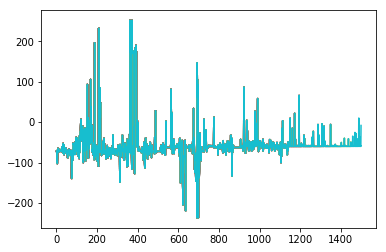

In [11]:
## TODO: Train your agent here.
from agents.DDPG import DDPG
import numpy as np
import sys
import pandas as pd

num_episodes = 1500
initial_pos = np.array([0., 0., 20., 0., 0., 0.])
initial_velocity = (0., 0., 20.)

run_time= 5.0
target_pos = np.array([0., 0., 30.])
task = Task(target_pos=target_pos)
agent = DDPG(task) 


# Results log
results = {x : [] for x in labels}
# Best reward initialized is negative infinity
highest_score = -np.Inf
# Total rewards list
totalRewards = []
counter = []

file_output = 'results-ddpg.txt'
# Setting up the writer
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    
    for i_episode in range(1, num_episodes+1):
        state = agent.reset_episode() # start a new episode

        total_reward = 0
        while True:
            action = agent.act(state) 
            next_state, reward, done = task.step(action)
            
            # Calculating the total reward
            total_reward += reward
            to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
            
            agent.step(action, reward, next_state, done)
            state = next_state
            
            for ii in range(len(labels)):
                results[labels[ii]].append(to_write[ii])
                writer.writerow(to_write)
            
            if done:
                if (total_reward > highest_score):
                    highest_score = total_reward
                
                counter.append(i_episode)
                totalRewards.append(total_reward)
                
                print("\nEpisode: {}  Reward: {} highScore: {}".format(i_episode, total_reward, highest_score))
                print(to_write)
                
                if i_episode % 50 == 0:
                    plt.plot(counter, totalRewards)
                
                break
        sys.stdout.flush()


## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

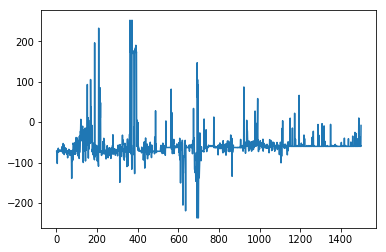

In [12]:
## TODO: Plot the rewards.
plt.plot(counter, totalRewards)

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**: I specified the task of trying to get the drone to hover at x: 0, y: 0, z: 30 with the default original starting position. 

As my aim was to be as close to the hover point as possible, I penalized the distance away from the x, y coordinates by **100*(abs(self.sim.pose[:2] - self.target_pos[:2])).sum()**. This was also backed up by **- 50 * (abs(self.sim.v[:2].sum()))** which penalizes the drove for having velocity in the x and y axis.

Initially, the z axis was included in the measure above but moved out as I noticed the drone was just crashing to the ground and not flying enough. Therefore, I added extra weighting to the z axis. After doing this, I noticed the drone just kept climbing up and up and not actually hovering. As a result, I provided great rewards for the drone's z axis veloticty to be going upwards. However, penalized it very heavily if it's velocity was still going up once it had crossed the hovering point on the z axis.

I did not want the drone to be spinning. Just want it to climb up in a stable fashion. As a result, I added a penality for it having any angular velocity by **- 5*(abs(self.sim.angular_v.sum()))**. Additionally, I didn't want the drone to tilt or spin. This would happen if any of the rotors were going faster or slower than the others. Therefore, penalized the angular acceleration as well by **- 3 *(abs(self.sim.angular_accels.sum()))**.

The sole aim of the reward function was to increase the altitude of the drone whilst stablely hovering over the origin.


**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**: I used the example classes to create a DDPG agent. In the Actor and Critic classes, I modified the neural network layers to add **batch_normalization** and **dropout** with probability of **0.2** for both the Actor and Critic classes. Additionally, used **relu** as the activation function in both classes for the intermediatiary layers in both classes. For the actor class, I used Sigmoid as the activation function in the final layer. 

The default values were used for alpha, gamma and epsilon. For **gamma**, the default value of **0.99** is a good value as it gives positive current reinforcement for good actions. However, it's also able to penalize any present action which might be good in the short term but severely, negatively affect the future.

As suggested by the previous review, I have experimented with several hyperparameter values for which I've put the html files in the repository. The first step I took was to reduce the learning rate of the **Actor** to **0.0001**. Along with this, the following hyperparameter values were set: 

**Attempt 1**

- $\mu$ = 0
- $\theta$ = 0.3
- $\sigma$ = 0.2
- $\gamma$ = 0.95
- $\tau$ = 0.001
- learning_rate = 0.0001

** Attempt 2 **

- $\mu$ = 0.2
- $\theta$ = 0.3
- $\sigma$ = 0.2
- $\gamma$ = 0.95
- $\tau$ = 0.001
- learning_rate = 0.0005

**Attempt 3 **

- $\mu$ = 0.1
- $\theta$ = 0.2
- $\sigma$ = 0.12
- $\gamma$ = 0.95
- $\tau$ = 0.02
- learning_rate = 0.0005

** Attempt 4 **

- $\mu$ = 0.2
- $\theta$ = 0.35
- $\sigma$ = 0.4
- $\gamma$ = 0.90
- $\tau$ = 0.0005
- learning_rate = 0.0005

After this attempt, the drone seems to be more explorative and trying out new methods quite a lot. As a result, the spikes in the reward are significantly higher in both positive and negative direction as excpected. However, the drone still doesn't seem to have learnt well as the reward hasn't gone up highly. __However,__ the drone's negative reward has been flat towards the end (no serious negative reward spikes) and the average was appearing to go up right towards the end.

**Actor - Batch Normalization, Dropout (prob=0.2), Activation='relu'**

- Dense(state_size)
- Dense(32)
- Dense(64)
- Dense(128)
- Dense(64)
- Dense(action_size, activation='sigmoid')

** Critic (state pathway) - Batch Normalization, Dropout (prob=0.2), Activation='relu'**

- Dense(state_size)
- Dense(32)
- Dense(64)
- Dense(128)

** Critic (action pathway) - Batch Normalization, Dropout (prob=0.2), Activation='relu'**

- Dense(action_size)
- Dense(32)
- Dense(64)
- Dense(128)

The layers between the critic and actor were combined with a relu activation function.

** Critic - Activation='relu'**

- Dense(1)

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**: This was not an easy task to learn. There were four rotors that had to be controlled independently. This made the task challenging due to the high number of variables that were changing between each episode. 
Having initially started off with the default architectures of the Actor and Critic classes; for both I added more layers and applied normalization techniques such as **dropout** and **batch normalization** to help it learn.

I am not sure if the drone learnt the task correctly in this project. It seemed to occasionally do really well and go near the hover point. (I got this as I had edited the task.py's step function to print of the current position at each step. Also the high reward.) On other attempts, it would be at a completely different location and have very low reward. This is clearly shown by the reward plot and the prints of the rewards above. 

The final performance wasn't great. It seems really random by how it has performed as there were sudden reward spikes but apart from that it's reward was fairly flat overall. However, in the final attempt, there were no negative reward spikes and it appeared that the average reward was starting to go up towards the end.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**: The hardest part of the project definitely was getting started. The other projects had examples that we had done previously to act as a guide for the final project. This did not. Furthermore, this was just a more complex project. However, the sample classes given did a lot with getting started.     

I really enjoyed working on this project as it's about deep reinforcement learning which is so often in this news for the work done by OpenAI for the Dota 2 bots, AlphaGo and the other games. Furthermore, to work on this project, I got to learn a lot about Monte Carlo methods, MDP and Temporal Learning which are all extremely important to learn anything about agent based systems.                 

I found it really odd about how the drone suddenly performed really well by going to the hoverpoint but on subsequent episodes, it didn't perform well at all.